In [1]:
%load_ext autoreload
%autoreload 2

In [65]:
from datetime import datetime
from types import SimpleNamespace
import os
from glob import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset
from dataset.normalization import MinMax, ZeroMinMax
from dataset.station_dataset import GroundstationDataset, GroundstationDataset2
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.ConvResNet_Jiang import ConvResNet, ConvResNet_dropout, ConvResNet_batchnormMLP
from models.LightningModule import LitEstimator, LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.plotting import prediction_error_plot
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
plt.rcParams['text.usetex'] = False

In [88]:
## Set Up Model

# ckpt_fn = "/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/vh232f2j/checkpoints/epoch=11-step=11928.ckpt"
ckpt_fn = "../train/SIS_point_estimation/wv1ykh5d/checkpoints/epoch=5-step=5964.ckpt"

inference_fn = ckpt_fn.split('checkpoints')[0] + 'inference/'
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)

config = {
    "batch_size": 1024,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS",],
    "x_features": ["dayofyear", "lat", "lon", 'SZA', "AZI",],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
    'max_epochs': 50,
    # Compute related
    'num_workers': 24,
    'ACCELERATOR': "gpu",
    'DEVICES': -1,
    'NUM_NODES': 32,
    'STRATEGY': "ddp",
    'PRECISION': "64",
    'EarlyStopping': {'patience':5},
    'ModelCheckpoint':{'every_n_epochs':1, 'save_top_k':3}
}
config = SimpleNamespace(**config)

In [89]:
ch = torch.load(ckpt_fn, map_location=torch.device('cpu'))
model = ConvResNet_batchnormMLP(
    num_attr=len(config.x_features),
    input_channels=len(config.x_vars),
    output_channels=len(config.y_vars),
)

In [90]:
estimator = LitEstimatorPoint(learning_rate=0.001, model=model, config=config)
estimator.load_state_dict(ch['state_dict'])

<All keys matched successfully>

In [106]:
zarr_fns = glob('/home/kr/Documents/Solar_Power_Forecasting/03_ground_stations/DWD/DWD_SOLAR_*.zarr')

datasets = [GroundstationDataset2(fn, config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], config.transform, config.target_transform)
            for fn in zarr_fns]

stations = [ds.name for ds in datasets]


53475 57202
52725 57158
52409 57163


In [98]:
dataset = torch.utils.data.ConcatDataset(datasets)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kr/.local/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/kr/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name          | Type                    | Params
----------------------------------------------------------
0 | model         | ConvResNet_batchnormMLP | 6.4 M 
1 | metric        | MeanSquaredError        | 0     
2 | other_metrics | MetricCollection        | 0     
---------------------------------------------

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/kr/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:11<00:00,  0.17it/s]tensor([-0.8677, -0.5226, -0.8217,  ..., -0.6232, -0.7584, -0.7297],
       dtype=torch.float64)
tensor([    nan,     nan,     nan,  ..., -0.7441,     nan,     nan],
       dtype=torch.float64)


ValueError: autodetected range of [nan, nan] is not finite

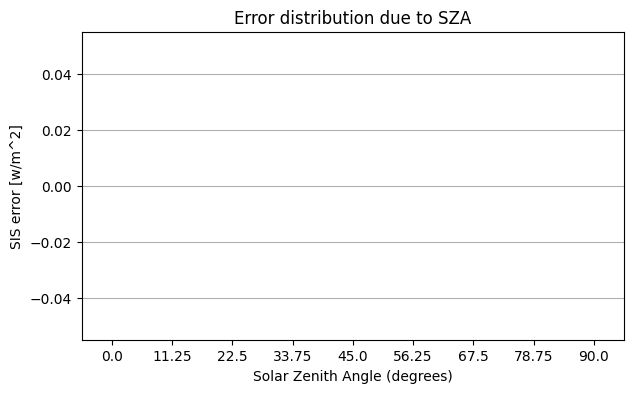

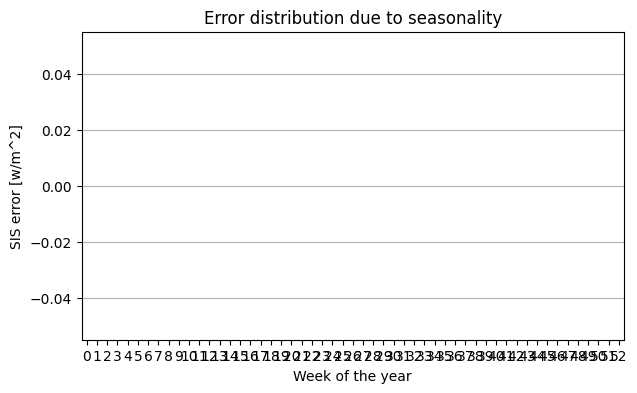

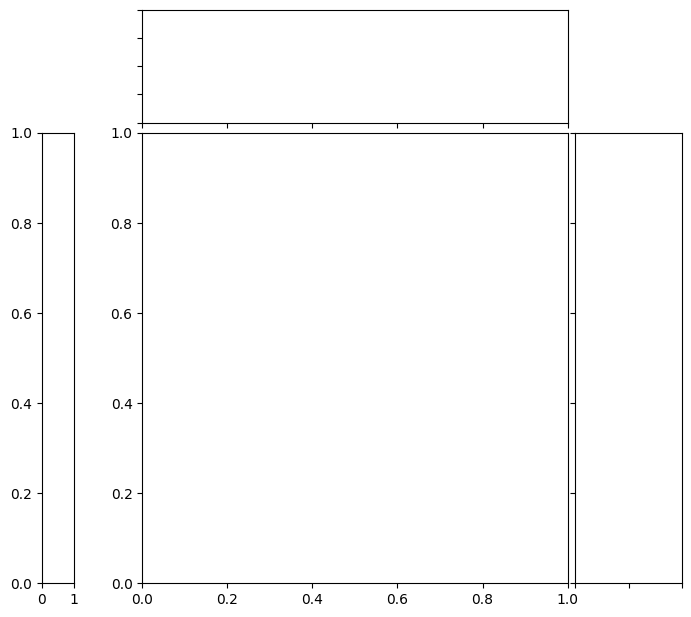

In [94]:
wandb_logger = WandbLogger(project="SIS_point_estimation")
trainer = Trainer(
    logger=wandb_logger,
    max_epochs=10,
    accelerator='cpu',
    precision=config.PRECISION,
)


trainer.fit(estimator, train_dataloader, val_dataloader)
